In [ ]:
'''
The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

The images for camera calibration are stored in the folder called `camera_cal`.  
The images in `test_images` are for testing your pipeline on single frames.  
If you want to extract more test images from the videos, you can simply use an image writing method like `cv2.imwrite()`, 
i.e., you can read the video in frame by frame as usual, and for frames you want to save for later you can write to an image file.  

To help the reviewer examine your work, please save examples of the output from each stage of your pipeline in the folder called 
`output_images`, and include a description in your writeup for the project of what each image shows.    
The video called `project_video.mp4` is the video your pipeline should work well on.  

The `challenge_video.mp4` video is an extra (and optional) challenge for you if you want to test your pipeline under somewhat 
trickier conditions.  The `harder_challenge.mp4` video is another optional challenge and is brutal!

If you're feeling ambitious (again, totally optional though), don't stop there! 
We encourage you to go out and take video of your own, calibrate your camera and show us how you would implement this project from scratch!
'''

In [7]:
# import libraries
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
%matplotlib inline

In [8]:
# some utility functions

# get images from dir
def ImagesFromDir(dir_name):
    image_names = os.listdir(dir_name)
    image_paths = [dir_name+ '/'+ image_name for image_name in image_names]
    images = [mpimg.imread(image_path) for image_path in image_paths]
    return images

# take chessboard images and return the object points and image points
def GetObjImagePoints(images,chessboard_grid=(9,6)):
    objpoints = [] # 3D points in real world space
    imgpoints = [] # 2D points in image plane
    for img in images:
        objpoint = np.zeros((chessboard_grid[1]*chessboard_grid[0],3),np.float32 )
        objpoint[:,:2]= np.mgrid[0:chessboard_grid[0],0:chessboard_grid[1]].T.reshape(-1,2)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, chessboard_grid, None)
        if True == ret:
            objpoints.append(objpoint)
            imgpoints.append(corners)
    return objpoints,imgpoints

# return undistorted image
def UndistortImage(image, objpoints, imgpoints):
    # Use cv2.calibrateCamera() and cv2.undistort()
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, image.shape[1::-1], None, None)
    dst = cv2.undistort(image, mtx, dist, None, mtx)
    return dst

# Define a function that applies Sobel x or y, 
# then takes an absolute value and applies a threshold.
# Note: calling your function with orient='x', thresh_min=5, thresh_max=100
# should produce output like the example image shown above this quiz.
# def AbsSobelThreshold(img, orient='x', thresh_min=0, thresh_max=255):
# call example: grad_binary = AbsSobelThreshold(image, orient='x', thresh=(20,100))
def AbsSobelThreshold(img, orient='x', thresh=(0, 255)):
    # Apply the following steps to img
    
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
   
    # 3) Take the absolute value of the derivative or gradient
    if 'x' == orient:
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    elif 'y' == orient:
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
   
        
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    mask = (scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])
    
    
    # 6) Return this mask as your binary_output image
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[mask] = 1
    
    return binary_output

# Define a function that applies Sobel x and y, 
# then computes the magnitude of the gradient
# and applies a threshold
# call example: mag_binary = MagThreshold(image, sobel_kernel=3, mag_thresh=(30, 100))
def MagThreshold(img, sobel_kernel=3, mag_thresh=(0, 255)):
    
    # Apply the following steps to img
    
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # 3) Calculate the magnitude 
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    
    # 5) Create a binary mask where mag thresholds are met
    binary_output = np.zeros_like(gradmag)
    
    # 6) Return this mask as your binary_output image
    mask = (gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])
    
    binary_output[mask] = 1
    
    
    return binary_output

# Define a function that applies Sobel x and y, 
# then computes the direction of the gradient
# and applies a threshold.
# call example: dir_binary = DirThreshold(image, sobel_kernel=15, thresh=(0.7, 1.3))
def DirThreshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # 3) Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    absgraddir = np.arctan2(abs_sobely, abs_sobelx)
    
    # 5) Create a binary mask where direction thresholds are met
    binary_output =  np.zeros_like(absgraddir)
    
    # 6) Return this mask as your binary_output image
    mask = (absgraddir >= thresh[0]) & (absgraddir <= thresh[1])
    binary_output[mask] = 1
    
    return binary_output

# Define a function that thresholds the S-channel of HLS
# Use exclusive lower bound (>) and inclusive upper (<=)
# call example: hls_binary = HlsThreshold(image, thresh=(90, 255))
def HlsThreshold(img, thresh=(0, 255)):
    # 1) Convert to HLS color space
    hls_img = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    
    # 2) Apply a threshold to the S channel
    s_hls_img = hls_img[:,:,2]
    
    # 3) Return a binary image of threshold result
    binary_output = np.zeros_like(s_hls_img)
    binary_output[(s_hls_img > thresh[0]) & (s_hls_img <= thresh[1])] = 1
    
    return binary_output

def LuvThreshold(img, thresh=(0, 255)):
    luv = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    l_channel = luv[:,:,0]
    binary_output = np.zeros_like(l_channel)
    binary_output[(l_channel > thresh[0]) & (l_channel <= thresh[1])] = 1
    return binary_output

def LabThreshold(img, thresh=(0, 255)):
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
    b_channel = lab[:,:,2]
    binary_output = np.zeros_like(b_channel)
    binary_output[(b_channel > thresh[0]) & (b_channel <= thresh[1])] = 1
    return binary_output

def CombineThresholds(img):
    xthresh = AbsSobelThreshold(img, orient='x', thresh=(10, 230))
    magthresh = MagThreshold(img, sobel_kernel=3, mag_thresh=(30, 150))
    dirthresh = DirThreshold(img, sobel_kernel=3, thresh=(0.7, 1.3))
    hlsthresh = HlsThreshold(img, thresh=(179, 255))
    labthresh = LabThreshold(img, thresh=(153, 200))
    luvthresh = LuvThreshold(img, thresh=(222, 255))
    
    #thresholds combination
    threshholded = np.zeros_like(xthresh)
    threshholded[((xthresh == 1) & (magthresh == 1)) | ((dirthresh == 1) & (hlsthresh == 1)) | (labthresh == 1) | (luvthresh == 1)] = 1
    

    return threshholded

# perspective transform 
# get transform matrix M (src -> dst)
# get transform matrix INV_M (dst -> src)
def GetPerspectiveTransformMatrix():
    src = np.float32([[(203, 720), (585, 460), (695, 460), (1127, 720)]])
    dst = np.float32([[(320, 720), (320, 0), (960, 0), (960, 720)]])
   
    M = cv2.getPerspectiveTransform(src, dst)
    INV_M = cv2.getPerspectiveTransform(dst,src)
    return M,INV_M

# warp image
def WarpImage(image,transform_matrix):
    warped_image = cv2.warpPerspective(image, transform_matrix, image.shape[1::-1], flags=cv2.INTER_LINEAR)
    return warped_image
#
# left_fit, right_fit = FindLaneLine(warped_binary_image)
def FindLaneLine(warped_binary_image):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(warped_binary_image[warped_binary_image.shape[0]//2:,:], axis=0)
    
    # Create an output image to draw on and visualize the result    
    #out_img = np.dstack((warped_binary_image, warped_binary_image, warped_binary_image))
   
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    # HYPERPARAMETERS   
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Set height of windows - based on nwindows above and image shape 
    window_height = np.int(warped_binary_image.shape[0]/nwindows)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = warped_binary_image.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base    
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = warped_binary_image.shape[0] - (window+1)*window_height
        win_y_high = warped_binary_image.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image        
        #cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        #cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2)
        
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
                          (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
                           (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    
    
    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass
    
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]    
  
    
    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    return left_fit, right_fit

# get image (undistorted image + lane zone layer)
def DrawLaneZone(undistorted_image,warped_binary_image,inverse_matrix,left_fit, right_fit):        
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, warped_binary_image.shape[0]-1, warped_binary_image.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty
    
    # create an empty image layer, draw lane zone color on it.
    warped_zero = np.zeros_like(warped_binary_image).astype(np.uint8)
    warped_image_layer = np.dstack((warped_zero, warped_zero, warped_zero))    
    
    # construct points used by cv2.fillPoly
    points_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    points_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    points_polygon = np.hstack((points_left, points_right))    
    
    # draw color on warped empty image layer
    cv2.fillPoly(warped_image_layer, np.int_([points_polygon]), (0,255, 0))    
    
    # get origianl perspective image, by inverse matrix
    inverse_warped_image_layer = cv2.warpPerspective(warped_image_layer, inverse_matrix, (undistorted_image.shape[1], undistorted_image.shape[0])) 
    # combine undistorted image with "inverse warped image layer"
    undistorted_image_with_lane_zone = cv2.addWeighted(undistorted_image, 1, inverse_warped_image_layer, 0.5,0)
    
    return undistorted_image_with_lane_zone

# get radius of curvature and distance from car to road center
# curvature,distance_in_car_and_road_center = GetCurvatureAndPosition(warped_binary_image,left_fit, right_fit)
def GetCurvatureAndPosition(warped_binary_image,left_fit, right_fit):
    
    # Define y-value where we want radius of curvature
    ploty = np.linspace(0, warped_binary_image.shape[0]-1, warped_binary_image.shape[0] )
    leftx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    rightx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
  
    # Fit a second order polynomial to pixel positions in each fake lane line
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
   
    # Calculation of (radius of curvature)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    curvature = ((left_curverad + right_curverad) / 2)
    
    lane_width = np.absolute(leftx[warped_binary_image.shape[0]-1] - rightx[warped_binary_image.shape[0]-1])
    lane_xm_per_pix = 3.7 / lane_width
    car_position = (((leftx[warped_binary_image.shape[0]-1] + rightx[warped_binary_image.shape[0]-1]) * lane_xm_per_pix) / 2.0)
    road_center_position = ((warped_binary_image.shape[1] * lane_xm_per_pix) / 2.0)
    distance_in_car_and_road_center = car_position - road_center_position
    
    return curvature,distance_in_car_and_road_center

def DrawData(image, curvature, distance_car_to_road_center):
    font = cv2.FONT_HERSHEY_SIMPLEX
    
    curvature_text = "Curvature Radius: %.3f m" % (curvature)
    cv2.putText(image, curvature_text, (100, 150), font, 1, (255, 255, 255), 2)


    #(distance_car_to_road_center > 0)?(pos_text = "Right"):(pos_text = "Left")
    if distance_car_to_road_center > 0:
        pos_text = 'Right'
    else:
        pos_text = 'Left'
    
    distance_text = "Car is %.3f m %s of center" % (abs(distance_car_to_road_center), pos_text)
    cv2.putText(image, distance_text, (100, 200), font, 1, (255, 255, 255), 2)
    return image

    
# return image(undistorted image + lane zone + curvature and radius data)
def Pipline(img):
    # 1. get one distort image
    #distorted_image = img

    # 2. get undistorted image
    undistorted_image = UndistortImage(img, object_points, image_points)    

    # 3. threshhold image
    threshhold_image = CombineThresholds(undistorted_image)

    # 4. perspective transform
    warped_image = WarpImage(threshhold_image,M)
    
    # 5. find lines    
    left_fit, right_fit = FindLaneLine(warped_image)        
        
    # 6. undistorted image with lane zone image layer
    undistorted_image_with_lane_zone = DrawLaneZone(undistorted_image,warped_image,INV_M,left_fit, right_fit)
    
    # 7. show image (undistorted image + lane zone + curvature and radius data)
    curvature , distance = GetCurvatureAndPosition(warped_image,left_fit, right_fit)
    show_image = DrawData(undistorted_image_with_lane_zone, curvature, distance)
    
    return show_image

In [9]:
# camera calibration
# get objpoints and imgpoints for UndistortImage function
camera_cal_images = ImagesFromDir("camera_cal")
object_points, image_points = GetObjImagePoints(camera_cal_images)


In [10]:
# get perspective transform matrix M(src->dst) and INV_M(dst->src)
M, INV_M = GetPerspectiveTransformMatrix()


In [11]:
# get test images
test_images = ImagesFromDir("test_images")

True

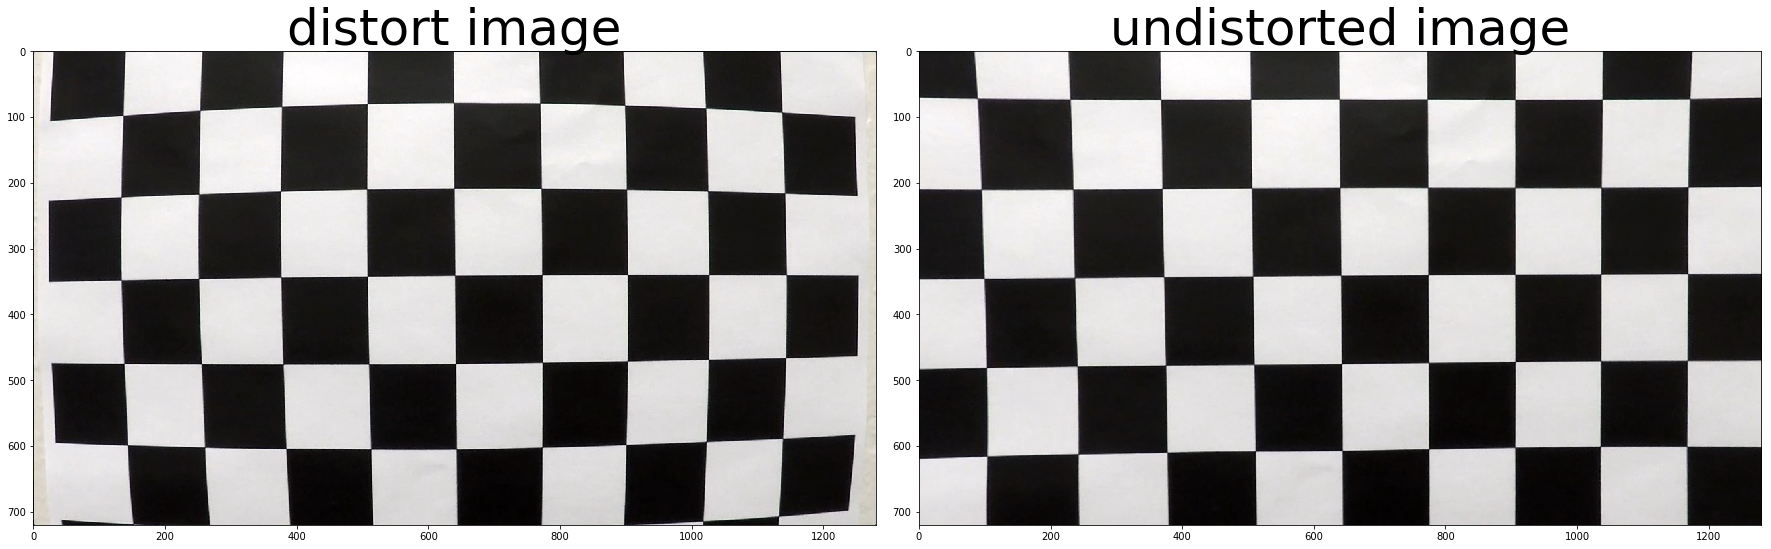

In [16]:
# undistorted image example

distort_image = mpimg.imread("camera_cal/calibration1.jpg")
undistorted_image = UndistortImage(distort_image, object_points, image_points)   

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(distort_image)
ax1.set_title('distort image', fontsize=50)
ax2.imshow(undistorted_image)
ax2.set_title('undistorted image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

cv2.imwrite("output_images/undistorted_image.jpg", undistorted_image)


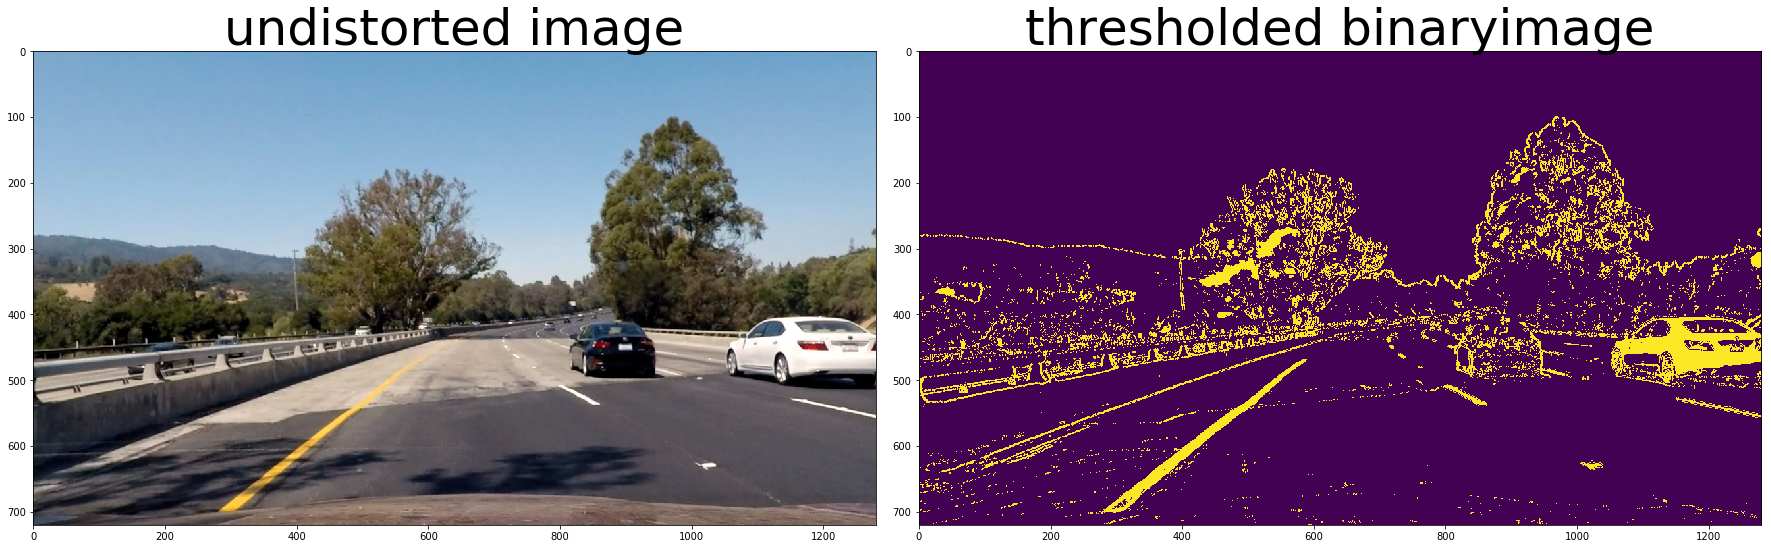

In [19]:
# thresholds combination example
undistorted_image = UndistortImage(test_images[5], object_points, image_points)   
thresholded_binary_image = CombineThresholds(undistorted_image)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(undistorted_image)
ax1.set_title('undistorted image', fontsize=50)
ax2.imshow(thresholded_binary_image)
ax2.set_title('thresholded binaryimage', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

plt.imsave("output_images/thresholded_image.jpg", thresholded_binary_image)

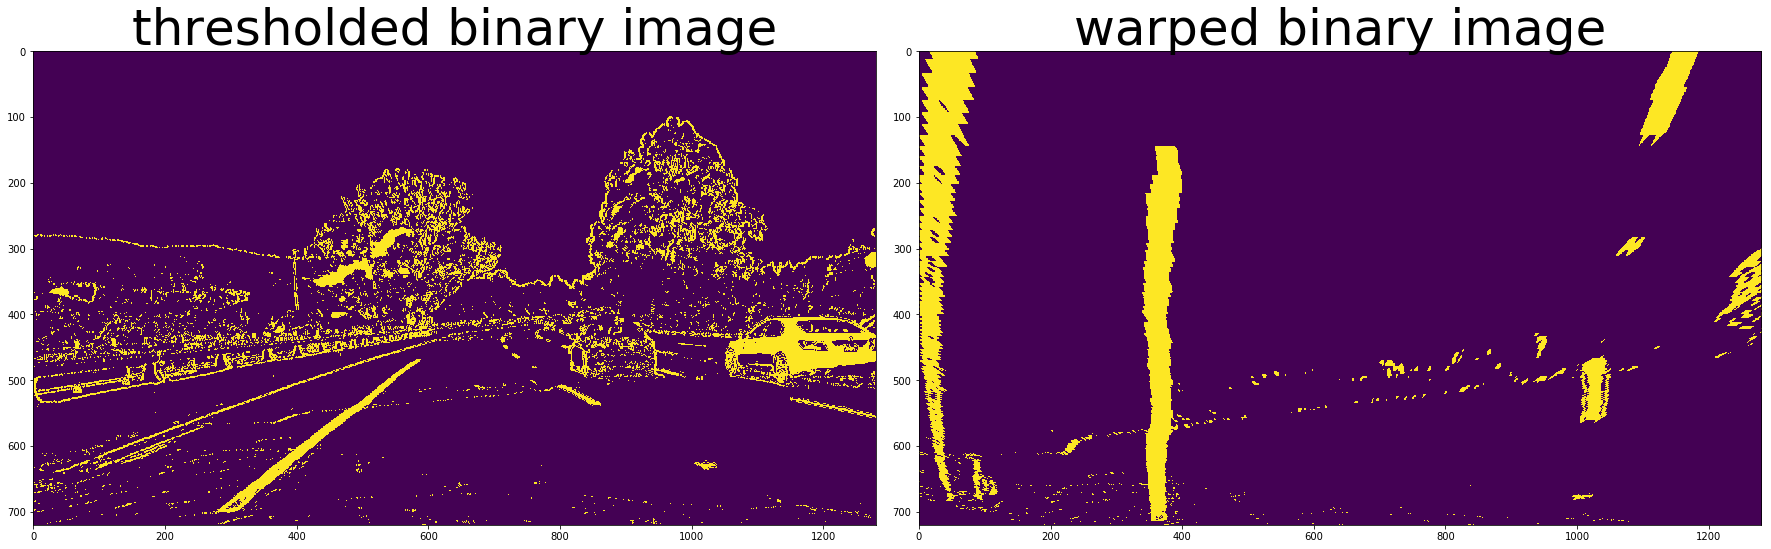

In [20]:
# perspective transfrom example
undistorted_image = UndistortImage(test_images[5], object_points, image_points)   
thresholded_binary_image = CombineThresholds(undistorted_image)
warped_image = WarpImage(thresholded_binary_image,M)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(thresholded_binary_image)
ax1.set_title('thresholded binary image', fontsize=50)
ax2.imshow(warped_image)
ax2.set_title('warped binary image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

plt.imsave("output_images/warped_binary_image.jpg", warped_image)

True

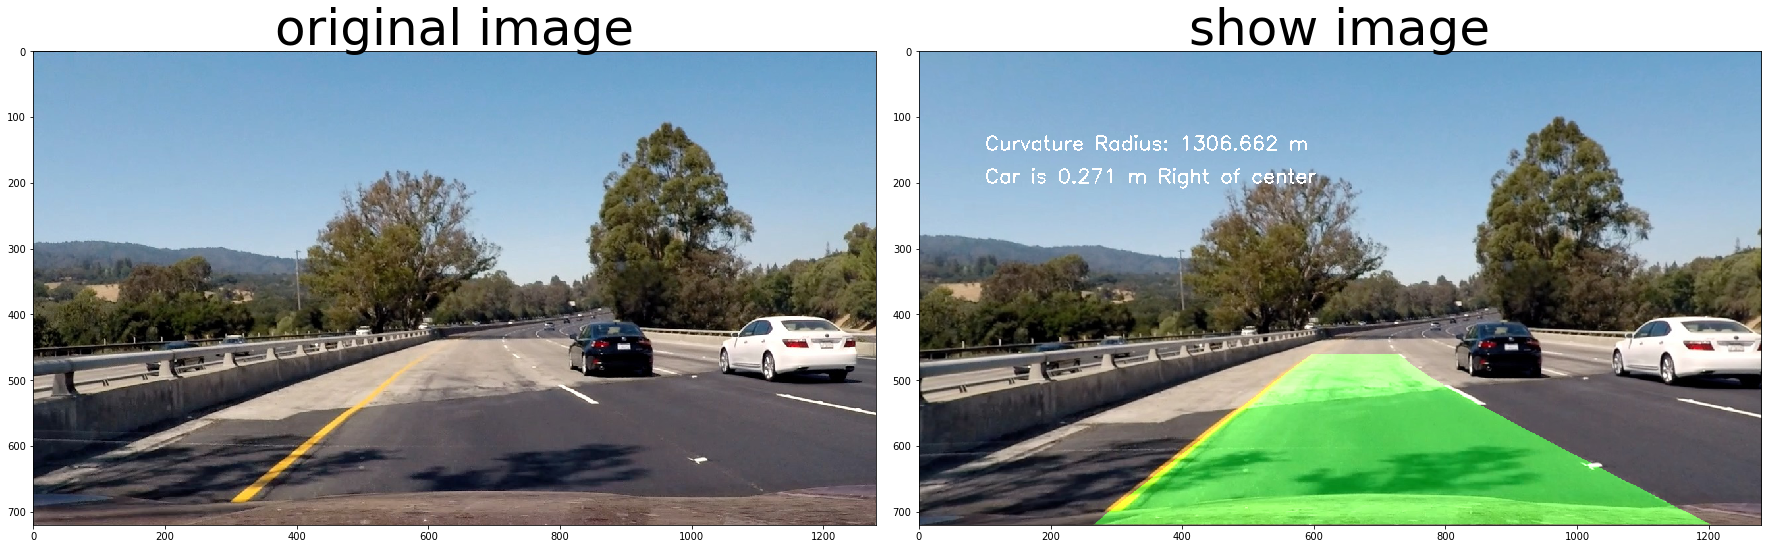

In [22]:
# Pipline example

distort_image = mpimg.imread("test_images/test4.jpg")
show_image = Pipline(distort_image)  

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(distort_image)
ax1.set_title('original image', fontsize=50)
ax2.imshow(show_image)
ax2.set_title('show image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

cv2.imwrite("output_images/pipline_image.jpg", show_image)

In [ ]:
undistorted_image = UndistortImage(test_images[5], object_points, image_points)    
thresholded_image = CombineThresholds(undistorted_image)
warped_image = WarpImage(thresholded_image,M)
left_fit, right_fit = FindLaneLine(warped_image)
curvature , distance = GetCurvatureAndPosition(warped_image,left_fit, right_fit)
show_image = DrawData(undistorted_image, curvature, distance)
plt.imshow(show_image)

In [6]:
from moviepy.editor import VideoFileClip
video_output_path = 'output_videos/project_video_output.mp4'
project_video_clip = VideoFileClip("project_video.mp4")
project_video_output_clip = project_video_clip.fl_image(lambda clip: Pipline(clip))
project_video_output_clip.write_videofile(video_output_path, audio=False)

[MoviePy] >>>> Building video output_videos/project_video_output.mp4
[MoviePy] Writing video output_videos/project_video_output.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [20:45<00:01,  1.01s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/project_video_output.mp4 



In [ ]:
cap = cv2.VideoCapture('project_video.mp4')  

begin_processing()
while(cap.isOpened()):  
    ret, frame = cap.read()  
    processed_frame = Pipline(frame)
    cv2.imshow('image', processed_frame)    
    k = cv2.waitKey(20)  
    #q键退出
    if (k & 0xff == ord('q')):  
        break  

cap.release()  
cv2.destroyAllWindows()


In [ ]:
# test image undistort

# Plot the result                        

for image in test_images:
   
    undistorted_image = UndistortImage(image, object_points, image_points)    
     
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(image)
    ax1.set_title('distorted image', fontsize=50)
    ax2.imshow(undistorted_image)
    ax2.set_title('undistorted image', fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [ ]:
# test undistorted image to warped image

# Plot the result                        

for image in test_images:
   
    undistorted_image = UndistortImage(image, object_points, image_points)    
     
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(undistorted_image)
    ax1.set_title('undistorted image', fontsize=50)
    warped_image = WarpImage(undistorted_image,M)
    ax2.imshow(warped_image)
    ax2.set_title('warped image', fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [ ]:
# test undistorted image -> binary image
for image in test_images:
   
    undistorted_image = UndistortImage(image, object_points, image_points)    
    threshholed_image = CombineThresholds(undistorted_image)
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(undistorted_image)
    ax1.set_title('undistorted image', fontsize=50)
    
    ax2.imshow(threshholed_image)
    ax2.set_title('thresholded image', fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [ ]:
# thresholed binary image -> warped binary image
for image in test_images:
   
    undistorted_image = UndistortImage(image, object_points, image_points)    
    thresholded_image = CombineThresholds(undistorted_image)
    warped_image = WarpImage(thresholded_image,M)
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(thresholded_image)
    ax1.set_title('thresholded image', fontsize=50)
    
    ax2.imshow(warped_image)
    ax2.set_title('warped image', fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)